In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.5, df = 4, n_sources = NumberofSources, size_sources = N , decreasing_correlation = True)
S = 2 * S -1 
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 32.769992061032156


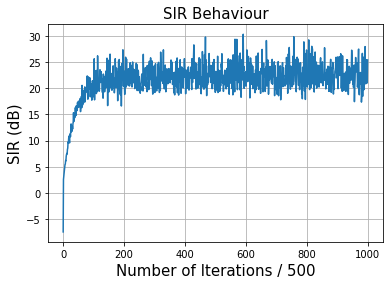

100%|█████████████████████████████████| 500000/500000 [04:35<00:00, 1814.36it/s]


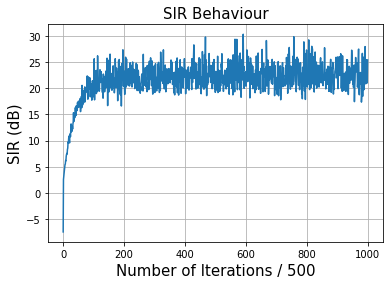

In [4]:
muW =2e-3
p = 1
bet = 30
r = NumberofSources
M = NumberofMixtures
debug_iteration_point = 500

modelWhitening = OnlineWhiten(s_dim = r, x_dim = M, muW = muW, p = p, bet = bet)

modelWhitening.fit_batch_whiten(X = X, n_epochs = 1, neural_dynamic_iterations = 150, neural_lr_start = .1, 
                       neural_lr_stop = 1e-3, shuffle = True, required_SIR = 90,
                       debug_iteration_point = debug_iteration_point, plot_in_jupyter = True)

In [5]:
display_matrix(np.corrcoef(X))

<IPython.core.display.Math object>

In [6]:
Wpre = modelWhitening.Winv
X = Wpre @ X
A = Wpre @ A

In [7]:
lambday = 1 - 1e-5/10
lambdae = 1 - 1e-6/10

s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 100 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 1e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-7,
                      set_ground_truth = True, S = S, A = A)

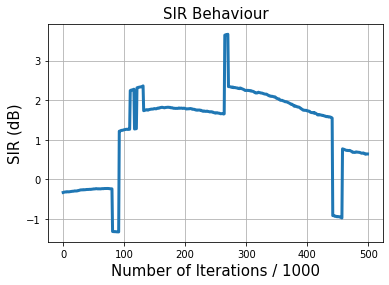

100%|█████████████████████████████████| 500000/500000 [01:27<00:00, 5716.02it/s]


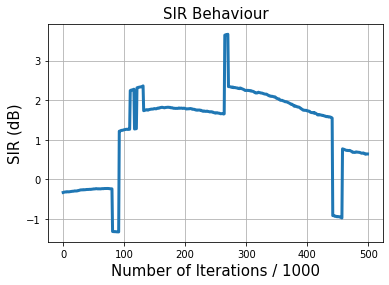

In [8]:
model.fit_batch_antisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 10,
                           plot_in_jupyter = True, neural_lr_start = .5,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                           shuffle = True)